Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287625
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.276170
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.124481
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.084436
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.095889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.184586
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.092853
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.068742
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.061789
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.125442

Training set: Average loss: 0.1757, Accuracy: 56823/60000 (94.70%)

Test set: Average loss: 0.0793, Accuracy: 9768/10000 (97.68%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.161770
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.034187
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.067425
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.135297
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025743
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.058925
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.052168
Train Epoch: 2 [44800/60000 (7

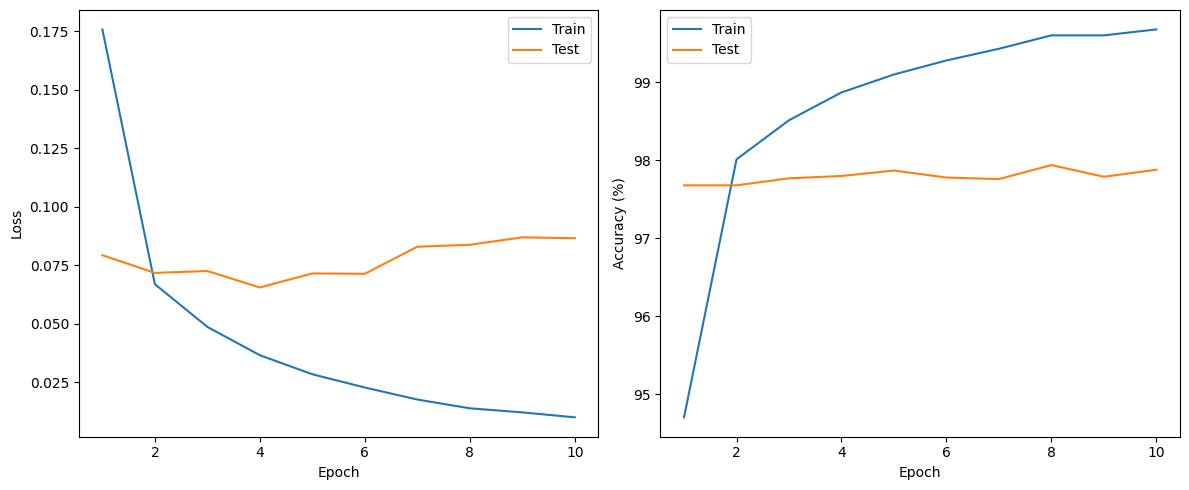

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.fc = nn.Linear(16 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(-1, 16 * 28 * 28)
        return self.fc(x)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# MNIST data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Training function
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f'\nTraining set: Average loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return train_loss, accuracy

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return test_loss, accuracy

# Training loop
epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train')
plt.plot(range(1, epochs+1), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accs, label='Train')
plt.plot(range(1, epochs+1), test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('mnist_results.png')
plt.show()